In [1]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, BasicTokenizer
import torch, csv
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

from transformers.models.t5.modeling_t5 import (
    T5ForConditionalGeneration as T5ForConditionalGenerationType,
)
from transformers.models.t5.tokenization_t5 import T5Tokenizer as T5TokenizerType

In [100]:
device = "cpu"
tokenizer: T5TokenizerType = T5Tokenizer.from_pretrained("./model/RewardRepair")
tokenizer.add_tokens(["{", "}", "<", "^"])

model: T5ForConditionalGenerationType = T5ForConditionalGeneration.from_pretrained(
    "./model/RewardRepair"
)
model = model.to(device)
model.eval()
bug = {
    "bugid": 69,
    "buggy": "buggy:    context:    private  final  boolean  removeGlobals;    private    void    removeUnreferencedFunctionArgs(Scope    fnScope)    {    Node    function    =    fnScope.getRootNode();    Preconditions.checkState(function.isFunction());    if    (NodeUtil.isGetOrSetKey(function.getParent()))    {    return;",
    "patch": "if    (!removeglobals)    {    return;    }    ",
}
# bug = {
#     "bugid": 69,
#     "buggy": "private  final  boolean  removeGlobals;    private    void    removeUnreferencedFunctionArgs(Scope    fnScope)    {    Node    function    =    fnScope.getRootNode();    Preconditions.checkState(function.isFunction());    if    (NodeUtil.isGetOrSetKey(function.getParent()))    {    return;",
#     "patch": "if    (!removeglobals)    {    return;    }    ",
# }
tokenizer.add_special_tokens(
    {
        "bos_token": "< /s>",
        "cls_token": "</s>",
        "mask_token": "<mask>",
        "sep_token": "</s>",
    }
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


2

In [3]:
raw_buggy = "private  final  boolean  removeGlobals;    private    void    removeUnreferencedFunctionArgs(Scope    fnScope)    {    Node    function    =    fnScope.getRootNode();    Preconditions.checkState(function.isFunction());    if    (NodeUtil.isGetOrSetKey(function.getParent()))    {    return;"

In [101]:
source = tokenizer([bug["buggy"]], max_length=512, return_tensors="pt").to(device)
input_ids: torch.Tensor = source["input_ids"]
attention_mask = source["attention_mask"]

return_sequences = 1

generated_ids = model.generate(
    inputs=input_ids.to(device, dtype=torch.long),
    attention_mask=attention_mask.to(device, dtype=torch.long),
    max_length=100, 
    num_beams=return_sequences,
    length_penalty=1.0, 
    early_stopping = True,
    num_return_sequences=return_sequences,
    num_beam_groups = 1,
    output_scores=True,
    return_dict_in_generate=True
)

preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids['sequences']]


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


`num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.


In [105]:
# print(preds)
# print(generated_ids.keys())
# print(type(generated_ids.scores))
# print(generated_ids.scores[0].shape)
# print(len(generated_ids.scores))
# print(generated_ids)
# print(attention_mask)
print(source)
input_tokens = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in source["input_ids"][0]]
print(input_tokens)

{'input_ids': tensor([[ 8524,  9559,    10,  2625,    10,  1045,   804,     3, 12840,   109,
           152,  2036, 31190,     7,   117,  1045,     3, 12186,  2036,  5110,
            60, 11788,    26,   371,   202,  4985, 16627,     7,   599,   134,
         10845,    15,     3,    89,    29,   134, 10845,    15,    61, 32100,
           465,   221,  1681,  3274,     3,    89,    29,   134, 10845,    15,
             5,  2782, 22778,    17,  4168,   221,  9960,   117,  1266, 17558,
             7,     5, 10031,   134,  4748,   599, 23993,     5,   159,   371,
           202,  4985,  9960,  3670,     3,    99,    41,  4168,   221,  1265,
            17,   173,     5,   159, 20361,  7395, 17175, 23617,   599, 23993,
             5,  2782, 13212,   295,  9960,    61,    61, 32100,  1205,   117,
             1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
print(model)

## SHAP

In [ ]:
import shap
import pandas as pd
import numpy as np
shap.initjs()

In [5]:
def generate_shap_values(model, tokenizer, seed, bug_string) -> shap._explanation.Explanation:
    explainer = shap.Explainer(model, tokenizer, seed=seed)
    shap_values = explainer([bug_string])
    return shap_values

In [9]:
def save_shap_values(shap_values: np.ndarray, filename: str):
    pd.DataFrame.to_csv(pd.DataFrame(shap_values), filename, index=False, header=False)

In [6]:
shap_values = generate_shap_values(model, tokenizer, 42, bug["buggy"])

Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:45, 45.55s/it]               


In [11]:
save_shap_values(shap_values.values[0], "shap_values.csv")

In [ ]:
shap.plots.text(shap_values)

In [29]:
import sys
np.set_printoptions(threshold=sys.maxsize)
print(shap_values.values[-1].tolist())

[[4.874089025904324e-10, 1.0883708612014854e-08, 8.686207823617918e-09, 2.551160506877986e-09, -2.981546494432741e-09, -1.2452851221265526e-10, -8.518836538962127e-10, -7.001366070236159e-09, -6.002608803531057e-09, -6.182556950192392e-09, -7.687753937497356e-09, 1.1113880061623206e-08, -1.1532525073798539e-09, 2.082032958076555e-09, 5.113903920698583e-09], [4.874089025904324e-10, 1.0883708612014854e-08, 8.686207823617918e-09, 2.551160506877986e-09, -2.981546494432741e-09, -1.2452851221265526e-10, -8.518836538962127e-10, -7.001366070236159e-09, -6.002608803531057e-09, -6.182556950192392e-09, -7.687753937497356e-09, 1.1113880061623206e-08, -1.1532525073798539e-09, 2.082032958076555e-09, 5.113903920698583e-09], [-9.748178051808645e-10, -2.1767417224029716e-08, -1.737241564723583e-08, -5.10232101375597e-09, 5.963092988865484e-09, 2.4905702442531063e-10, 1.7037673077924254e-09, 1.4002732140472318e-08, 1.2005217607062118e-08, 1.2365113900384788e-08, 1.537550787499472e-08, -2.222776012324642

In [13]:
selected_bugs = ["Closure_1", "Closure_86", "Closure_126", "Math_57", "Math_75", "Math_85", "Math_50"]

In [86]:
dataset_file = "data/D4JPairs.csv"
bugs_dataset = pd.read_csv(dataset_file, delimiter="\t")
results = bugs_dataset.loc[bugs_dataset["bug"] == "Closure_1", "buggy"]
print(type(results))
print(type(results.iloc[0]))

<class 'pandas.core.series.Series'>
<class 'str'>


In [95]:
from typing import List

def generate_shap_values_for_bugs(bug_dataset_file: str, selected_bugs: List[str], model, tokenizer):
    bugs_dataset = pd.read_csv(bug_dataset_file, delimiter="\t")
    shap_values_arr = []


    for bug_name in selected_bugs:
        results = bugs_dataset.loc[bugs_dataset["bug"] == bug_name, "buggy"]
        if results.size == 0:
            print(f"Bug {bug_name} not found in dataset")
        else:
            bug_string = results.iloc[0]
            shap_values_arr.append(generate_shap_values(model, tokenizer, 42, bug_string).values[0])
    return shap_values_arr

In [97]:
shap_values_arr = generate_shap_values_for_bugs(dataset_file, selected_bugs, model, tokenizer)

Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:07, 67.90s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:45, 45.41s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:29, 89.32s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:24, 84.26s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:40, 40.16s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:48, 108.70s/it]              


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:24, 84.38s/it]               


In [99]:
output_dir = "shap_values/"
for shap_values, bug_name in zip(shap_values_arr, selected_bugs):
    save_shap_values(shap_values, output_dir + bug_name + "_shap_values.csv")

### Aggregation

In [51]:
aggregated_shap_values = []

for feature in shap_values.values[0]:
    aggregated_shap_values.append(sum(feature))

print(aggregated_shap_values)
print(len(aggregated_shap_values))

[6.6778411496145555e-09, 6.6778411496145555e-09, 6.6778411496145555e-09, 6.6778411496145555e-09, 6.6778411496145555e-09, 6.6778411496145555e-09, 6.6778411496145555e-09, 6.6778411496145555e-09, 6.677841149614556e-09, 6.677841149614556e-09, 6.677841149614556e-09, 6.677841149614556e-09, 6.677841149614556e-09, 6.677841149614556e-09, 6.677841149614556e-09, 6.677841149614556e-09, 6.677841149614556e-09, 6.677841149614556e-09, 6.677841149614556e-09, 6.677841149614556e-09, 6.677841149614557e-09, 6.677841149614557e-09, 6.677841149614557e-09, 6.6778411496145555e-09, 6.6778411496145555e-09, 6.6778411496145555e-09, 6.6778411496145555e-09, 6.6778411496145555e-09, 6.677841149614556e-09, 6.677841149614556e-09, 6.677841149614556e-09, 6.677841149614556e-09, 6.677841149614556e-09, 6.677841149614556e-09, 6.677841149614556e-09, 6.677841149614556e-09, 6.677841149614556e-09, 6.677841149614556e-09, 6.677841149614556e-09, 6.677841149614556e-09, 6.677841149614556e-09, 6.677841149614556e-09, 6.677841149614556e-0

In [58]:
inputs = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in input_ids[0]]
print(inputs)
print(len(inputs))

['private', 'final', '', 'boo', 'le', 'an', 'remove', 'Global', 's', ';', 'private', '', 'void', 'remove', 'Un', 're', 'ference', 'd', 'F', 'un', 'ction', 'Arg', 's', '(', 'S', 'cop', 'e', '', 'f', 'n', 'S', 'cop', 'e', ')', '{', 'No', 'de', 'function', '=', '', 'f', 'n', 'S', 'cop', 'e', '.', 'get', 'Roo', 't', 'No', 'de', '()', ';', 'Pre', 'condition', 's', '.', 'check', 'S', 'tate', '(', 'function', '.', 'is', 'F', 'un', 'ction', '()', ');', '', 'if', '(', 'No', 'de', 'U', 't', 'il', '.', 'is', 'Get', 'Or', 'Set', 'Key', '(', 'function', '.', 'get', 'Par', 'ent', '()', ')', ')', '{', 'return', ';', '< /s>']
96


In [11]:
print(generated_ids.sequences[0])

tensor([    0,     3,    99,    41,    89,    29,   134, 10845,    15,     5,
         2782, 22778,    17,  4168,   221,  9960,  3274,  2423,   206,   195,
           61, 32100,  1205,   117, 32101,     1])


In [12]:
outputs = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids.sequences[0]]
print(outputs)

['< pad>', '', 'if', '(', 'f', 'n', 'S', 'cop', 'e', '.', 'get', 'Roo', 't', 'No', 'de', '()', '=', '=', 'nu', 'll', ')', '{', 'return', ';', '}', '< /s>']


### Softmax

In [17]:
import numpy as np
import scipy

In [10]:
def relu(matrix):
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            if matrix[i][j] < 0:
                matrix[i][j] = 0
    return matrix

In [18]:
relu_shap_values = relu(shap_values.values[0])

In [19]:
# rowise softmax
shap_values_sm_rows = scipy.special.softmax(relu_shap_values, axis=1)

In [20]:
# columnwise softmax
shap_values_sm_cols = scipy.special.softmax(relu_shap_values, axis=0)

In [21]:
# matrix softmax
shap_values_sm_mat = scipy.special.softmax(relu_shap_values)

#### Heatmap for Rowwise Softmax

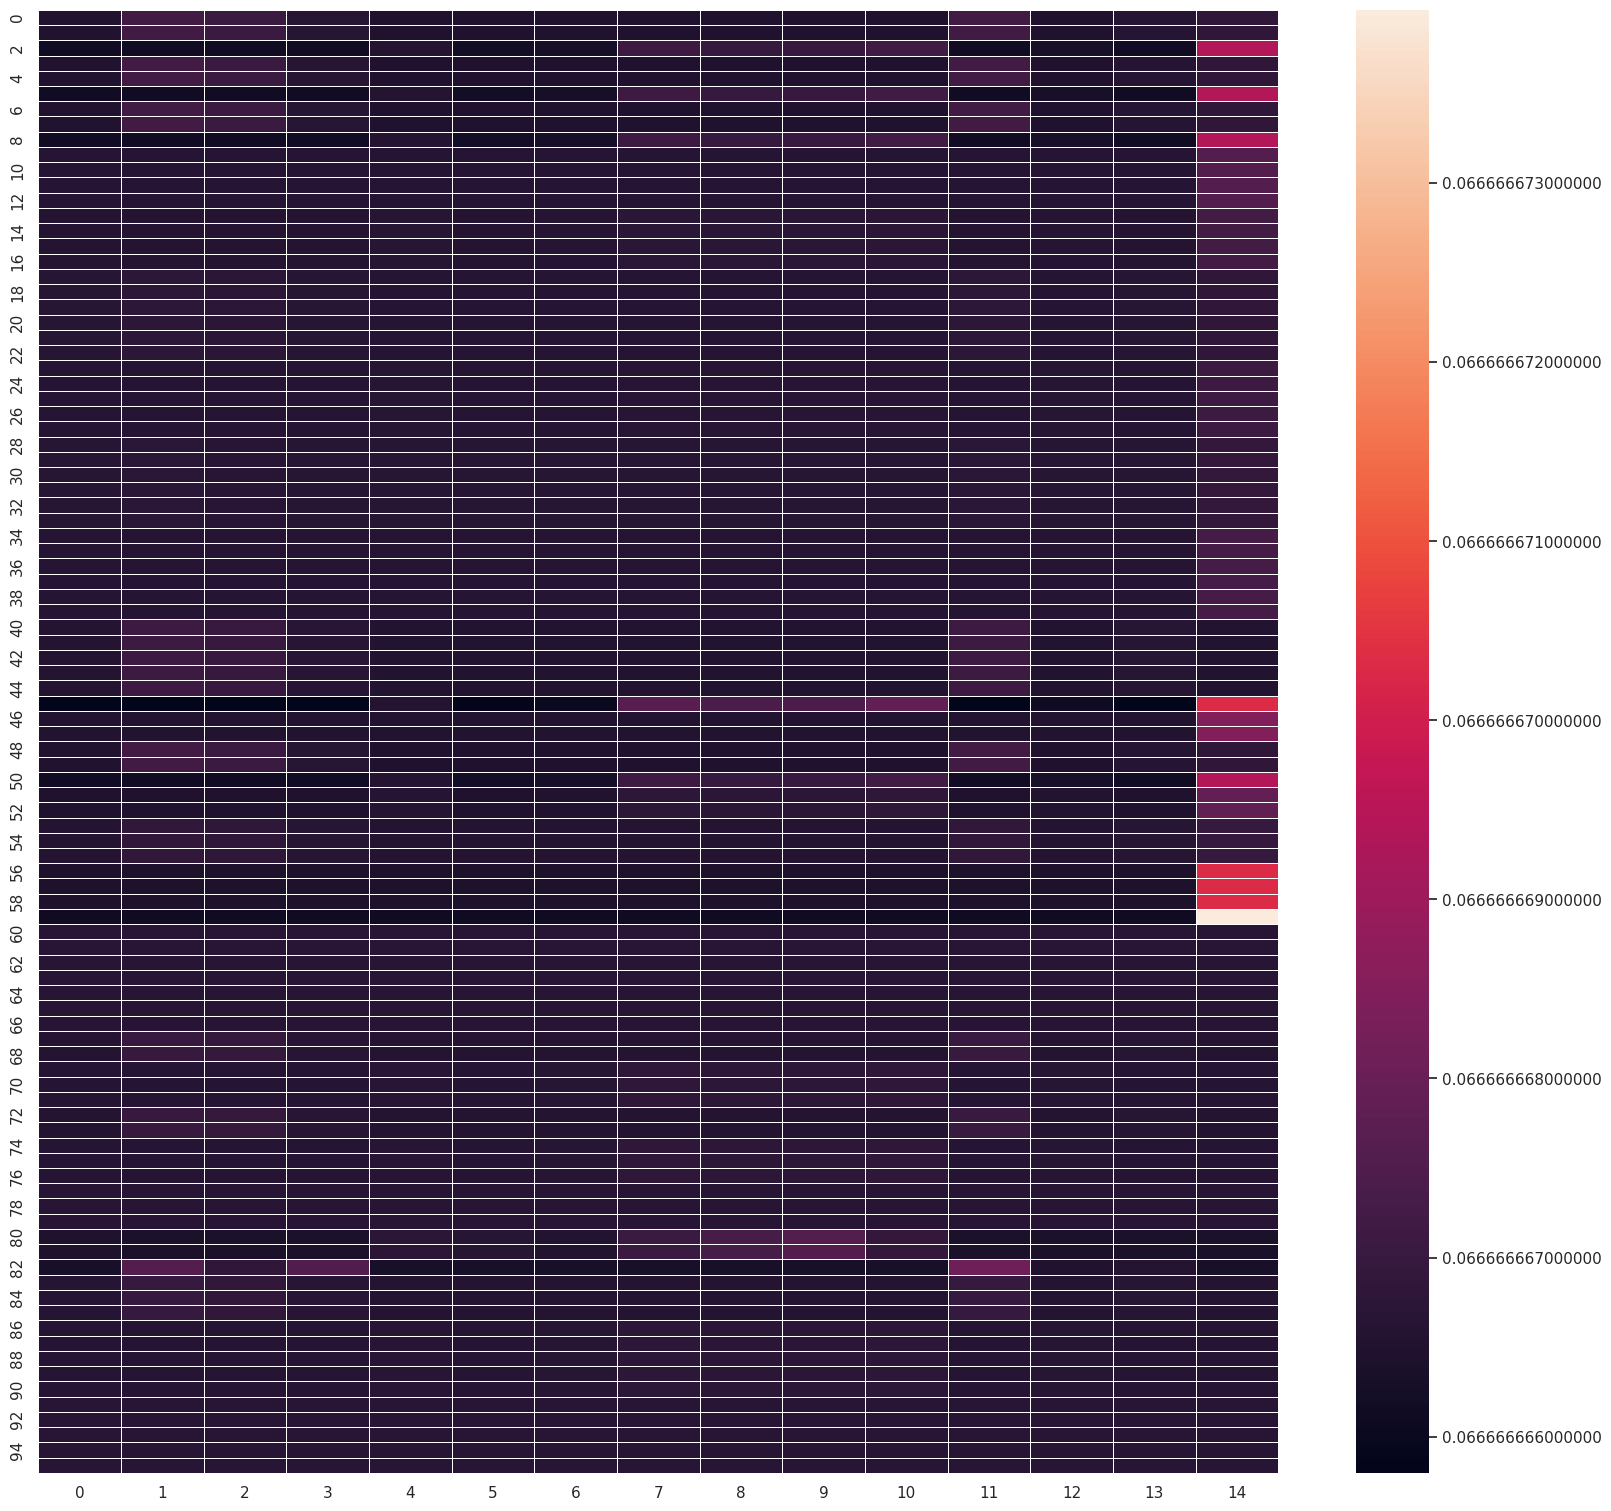

In [22]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# softmax shap values for rows

cb_params = {
    "format": ticker.StrMethodFormatter('{x:.15f}')
}

sns.set (rc = {'figure.figsize':(20, 19)})
sns.heatmap(shap_values_sm_rows, cbar_kws=cb_params, linecolor="white", linewidths=0.5)
plt.show()

#### Heatmap for Columnwise Softmax

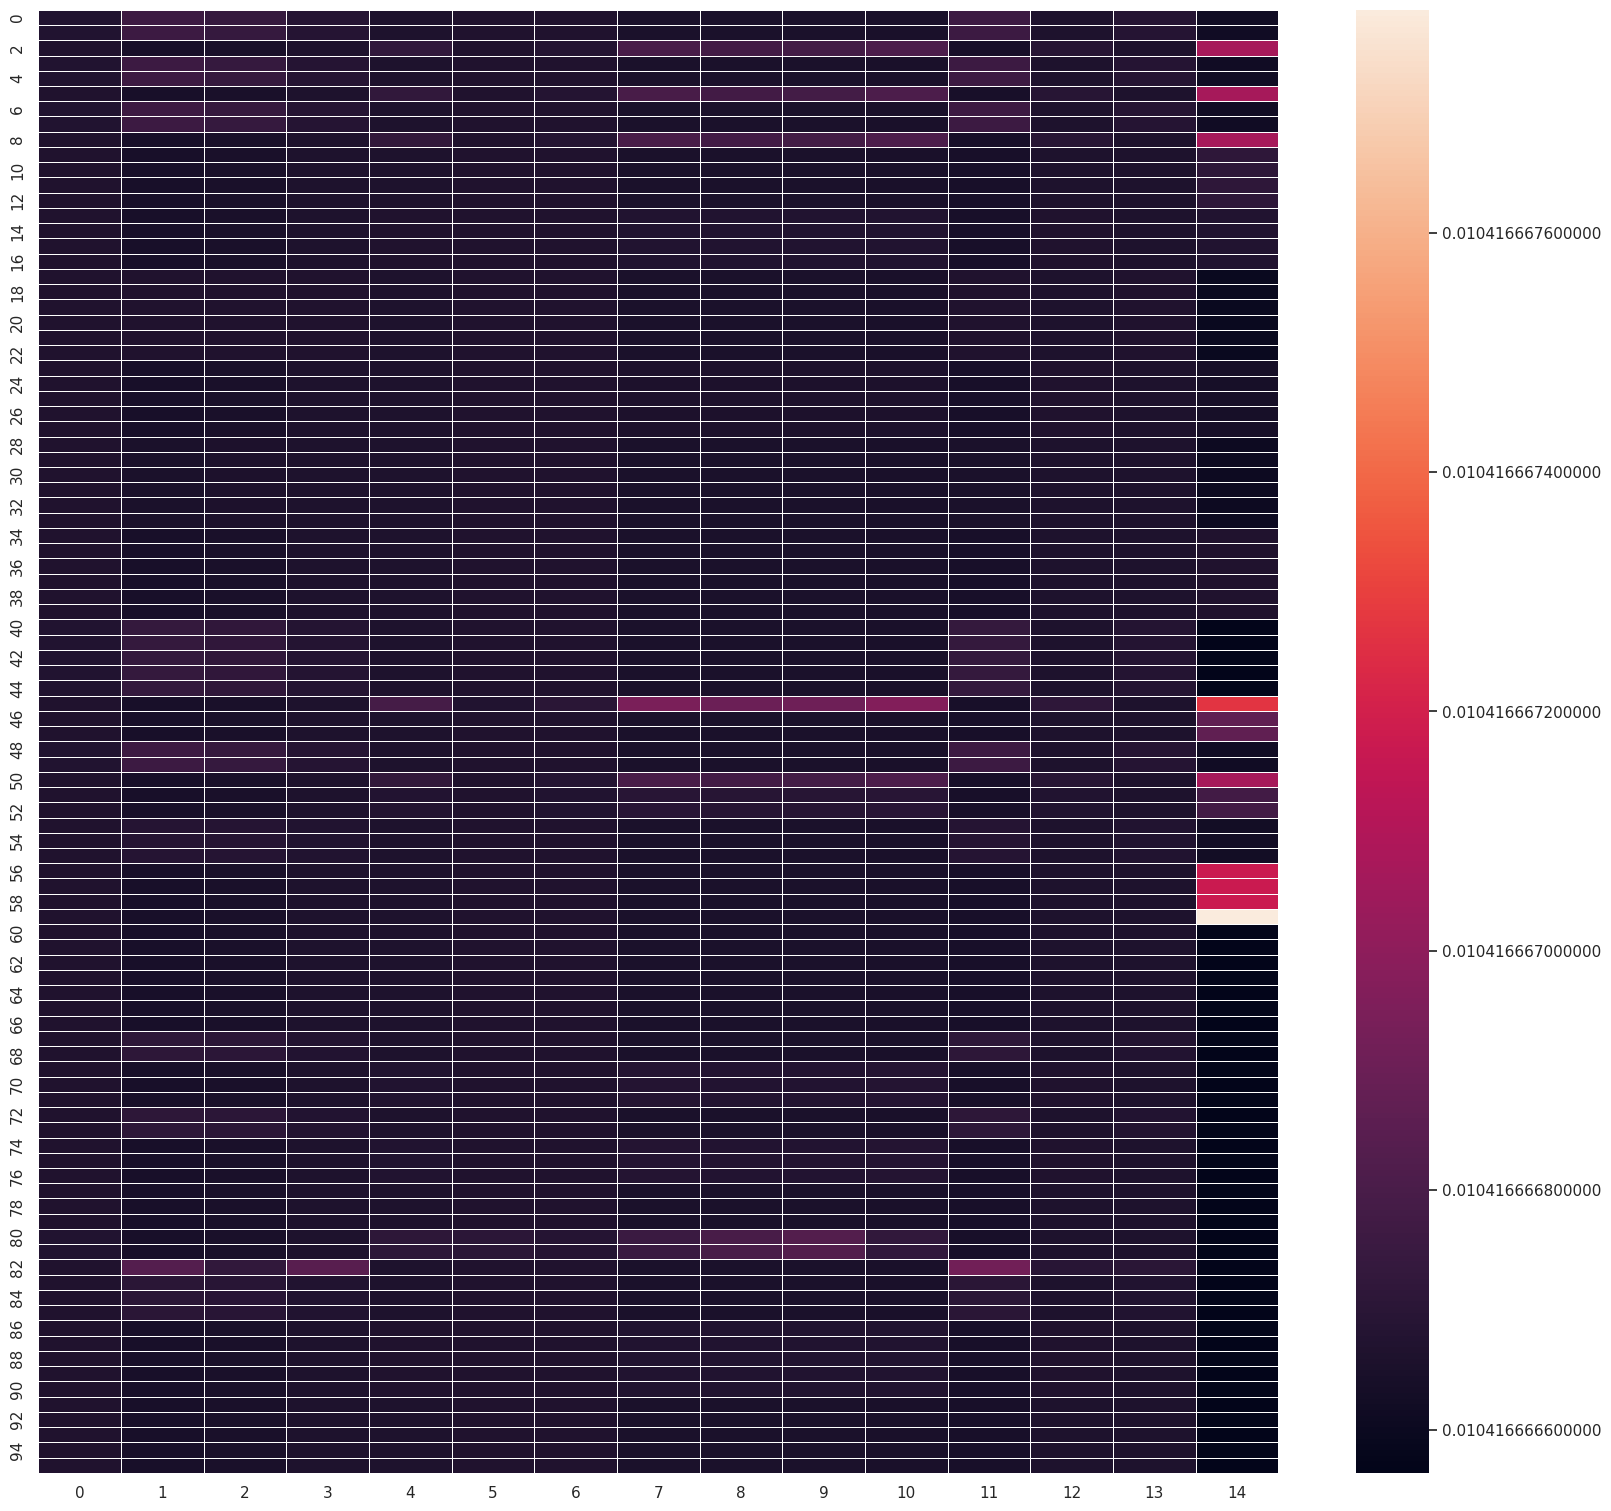

In [23]:
# softmax shap values for cols
sns.set (rc = {'figure.figsize':(20, 19)})
sns.heatmap(shap_values_sm_cols, cbar_kws=cb_params, linecolor="white", linewidths=0.5)
plt.show()

#### Heatmap for Applying Softmax to the Whole Matrix

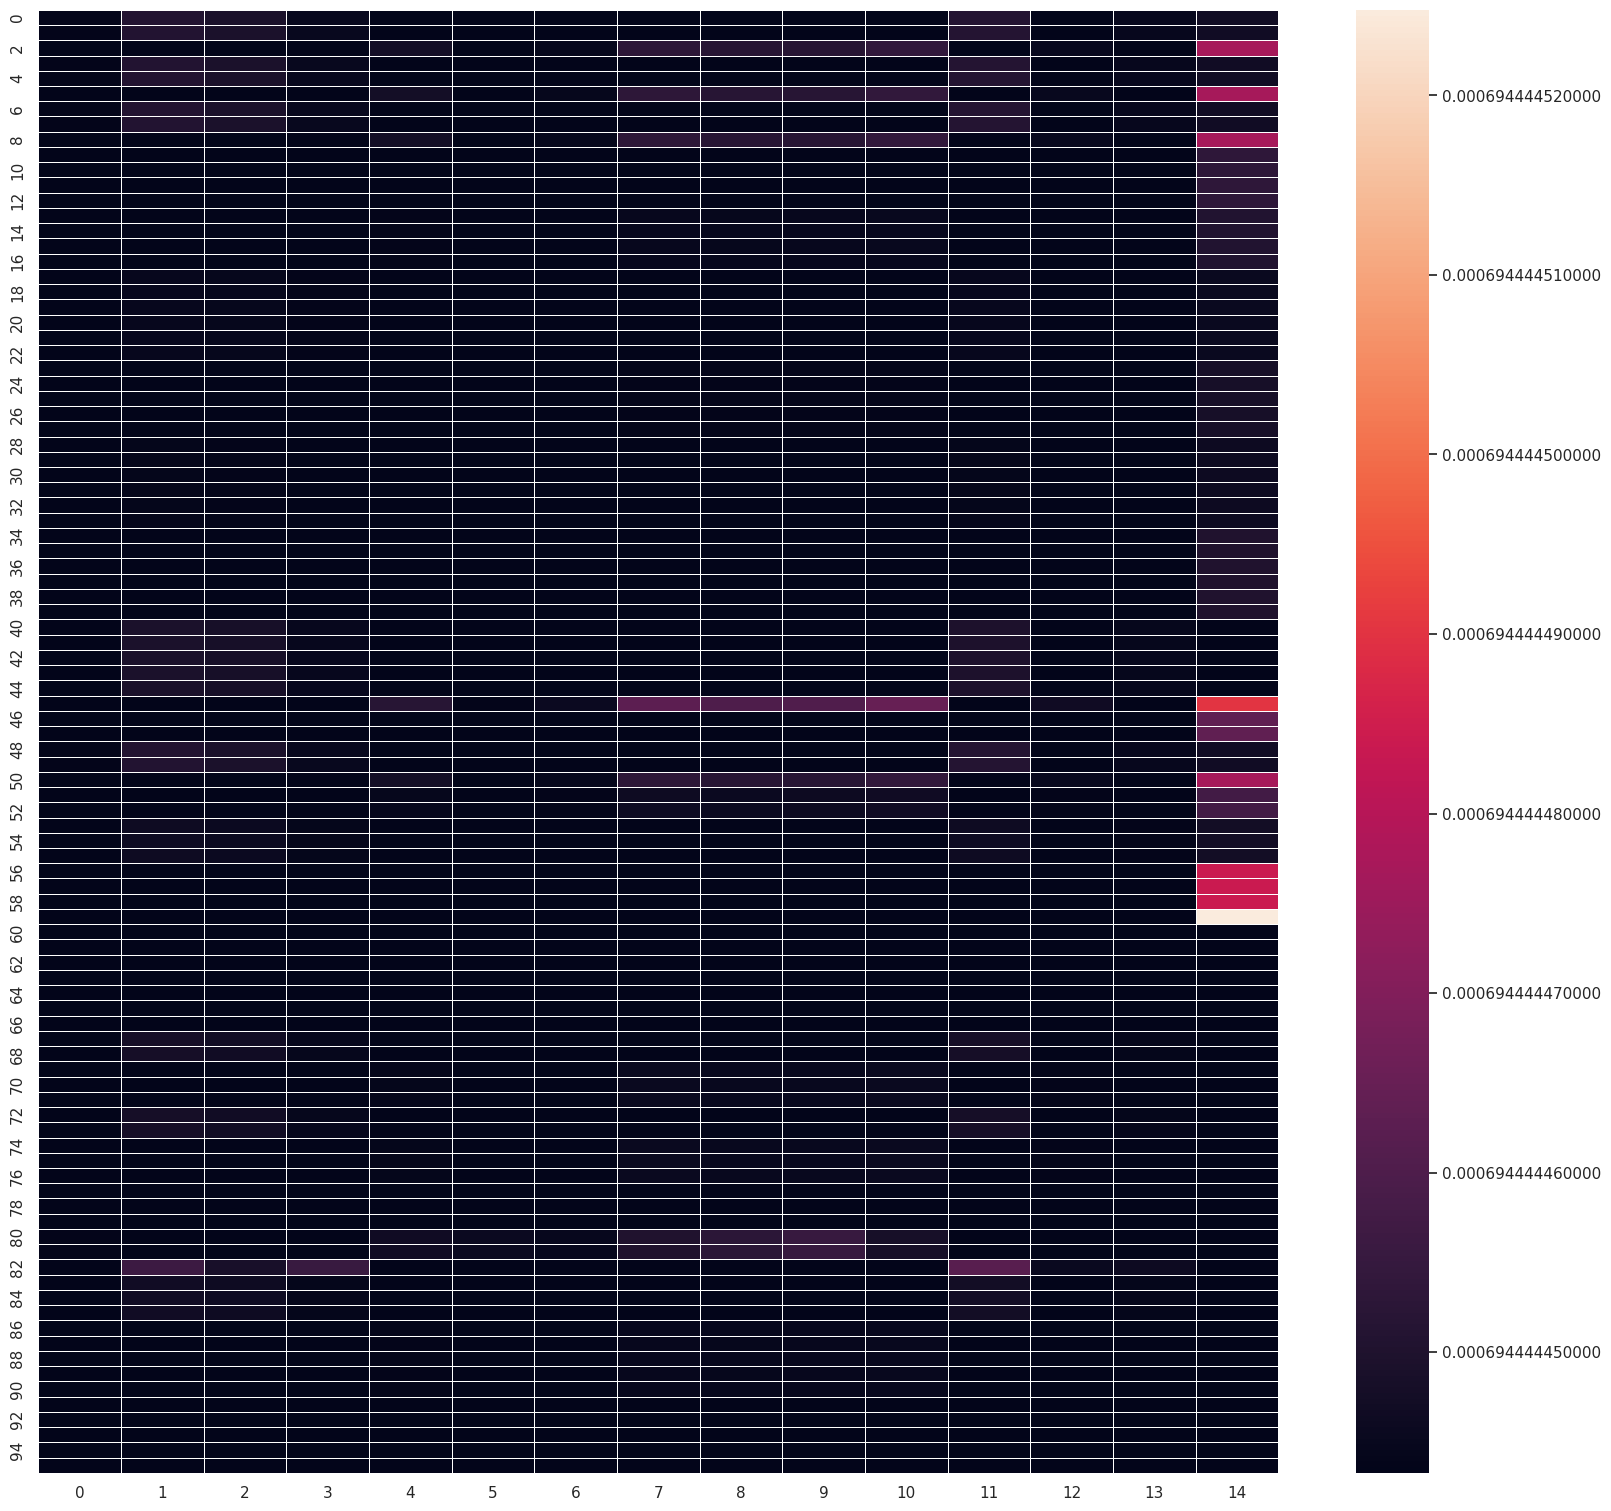

In [25]:
# softmax shap values for matrix
sns.set (rc = {'figure.figsize':(20, 19)})
sns.heatmap(shap_values_sm_mat, cbar_kws=cb_params, linecolor="white", linewidths=0.5)
plt.show()

# IG

In [5]:
type(model)

transformers.models.t5.modeling_t5.T5ForConditionalGeneration

In [6]:
model.get_input_embeddings()

Embedding(32128, 512)

In [5]:
from captum.attr import LayerIntegratedGradients

In [6]:
out = tokenizer('if', max_length=512, return_tensors="pt").to(device)
out_ids = out['input_ids']
print(out)

{'input_ids': tensor([[ 3, 99,  1]]), 'attention_mask': tensor([[1, 1, 1]])}


In [6]:
# input given to the model
print(type(input_ids))
input_ids.shape

<class 'torch.Tensor'>


torch.Size([1, 101])

In [7]:
ref = torch.zeros_like(input_ids)
print(ref.shape)
print(ref)

torch.Size([1, 101])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]])


In [8]:
# generated ids
print(generated_ids.sequences)
# preds = [tokenizer.decode(generated_ids.sequences[0], skip_special_tokens=True, clean_up_tokenization_spaces=True)]
# print(preds)
print(generated_ids.sequences.shape)

tensor([[    0,     3,    99,    41,    89,    29,   134, 10845,    15,     5,
          2782, 13212,   295,  9960,  3274,  2423,   206,   195,    61, 32100,
          1205,   117, 32101,     1]])
torch.Size([1, 24])


In [9]:
print("input_ids shape:", input_ids.shape)
print("ref shape:", ref.shape)
print("generated_ids.scores shape:", generated_ids.scores[0].shape)


input_ids shape: torch.Size([1, 101])
ref shape: torch.Size([1, 101])
generated_ids.scores shape: torch.Size([1, 32128])


In [8]:
lig = LayerIntegratedGradients(model.generate, model.get_input_embeddings())
attributions_ig, delta = lig.attribute(
    input_ids,
    ref,
    n_steps=40,
    return_convergence_delta=True,
    target=generated_ids.scores
)

RuntimeError: output with shape [40, 8, 1, 1] doesn't match the broadcast shape [40, 8, 1, 101]

In [9]:
a = [1, 2343, 234, 234]
input_indices = torch.tensor(a, device=device)
print("Before:", input_indices, input_indices.shape)
input_indices = input_indices.unsqueeze(0)
print("After:", input_indices, input_indices.shape)

Before: tensor([   1, 2343,  234,  234]) torch.Size([4])
After: tensor([[   1, 2343,  234,  234]]) torch.Size([1, 4])
